Implementation of Image Style Transfer with Convolutional Neural Networks (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

Using Pre-Trained VGG19 Model

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

### Hyperparameters

In [0]:
dir_loc = '/content/drive/My Drive/Colab Notebooks/Neural_Style_Transfer/'
IMAGE_SIZE = 256

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2
                }
content_weight = 1  # alpha
style_weight = 1e6  # beta


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
style_image = Image.open(dir_loc + 'style_images/great_wave.jpg')
style_image_test = style_image.resize((IMAGE_SIZE,IMAGE_SIZE))
style_image_arr = np.array(style_image_test)

content_image = Image.open(dir_loc + 'content_images/seattle.jpg')
content_image_test = content_image.resize((IMAGE_SIZE,IMAGE_SIZE))
content_image_arr = np.array(content_image_test)

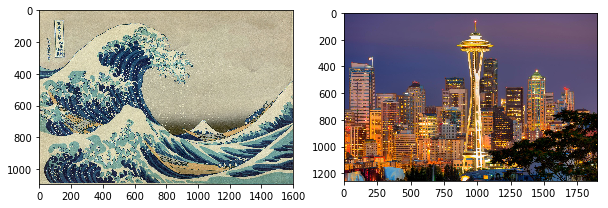

In [48]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(style_image)
axes[1].imshow(content_image)

In [37]:
inputs = [content_image, style_image]
def get_image_info(images):
  info = {
      'content' : None,
      'style' : None
  }
  for idx,im in enumerate(images):
    im = np.array(im)
    means,stds = cv2.meanStdDev(im)
    if idx == 0:
      info['content'] = (means,stds)
    elif idx == 1:
      info['style'] = (means,stds) 
  return info

img_info = get_image_info(inputs)
print(img_info)

{'content': (array([[102.98716274],
       [ 79.73234647],
       [ 82.41332762]]), array([[59.39685899],
       [42.36392646],
       [47.56333539]])), 'style': (array([[153.31459905],
       [159.65296123],
       [143.66709827]]), array([[68.79152768],
       [57.84182035],
       [40.41592394]]))}


In [0]:
content_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(tuple(img_info['content'][0]),tuple(img_info['content'][1]))
])

style_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(tuple(img_info['style'][0]),tuple(img_info['style'][1]))
])

gen_transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [0]:
# Convert to torch tensors
# style_image = torch.from_numpy(style_image)
# style_image = style_image.type(torch.FloatTensor)

# content_image = torch.from_numpy(content_image)
# content_image = content_image.type(torch.FloatTensor)

content = gen_transformer(content_image).to(device)
style = gen_transformer(style_image).to(device)

In [0]:
output = content.clone()
output.requires_grad = True
output = output.to(device)

In [41]:
vgg19 = torchvision.models.vgg19(pretrained=True).features
vgg19.to(device)
print(vgg19)
print()
print(vgg19._modules.items())

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def get_features(image,model):
  """Feature Retreival from forward
  pass"""
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
  }
  
  features = {}
  x = image
  x = torch.unsqueeze(x,0)
  for name,layer in model._modules.items():
    x = layer(x)
    if(name in layers):
      features[layers[name]] = x
  return features

def gram_matrix(tensor):
  """Generate Gram Matrix"""
  _,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.matmul(tensor,tensor.t())
  return gram

def unnorm_img(tensor):
  """tensor to image"""
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)
  return image

In [0]:
# Get "Ground Truth" Features from Original Image
gt_content_features = get_features(content, vgg19)
gt_style_features = get_features(style, vgg19)

style_grams = {layer: gram_matrix(gt_style_features[layer]) for layer in gt_style_features}

Total Loss: 149085296.0


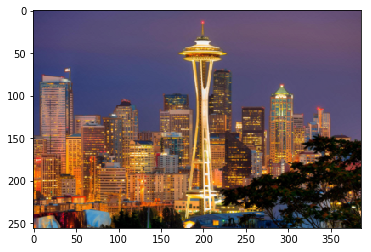

Total Loss: 75122944.0


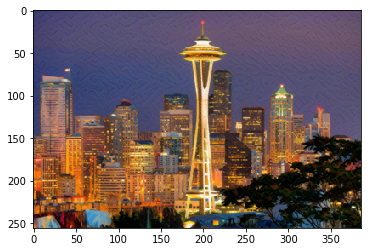

Total Loss: 52824180.0


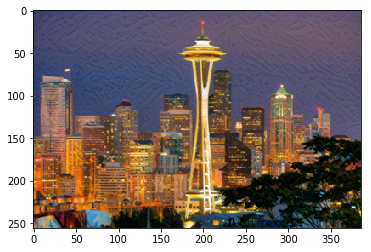

Total Loss: 38608520.0


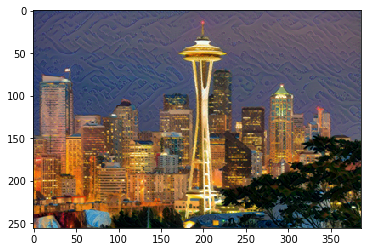

Total Loss: 28911484.0


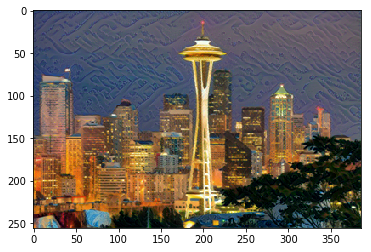

Total Loss: 22387110.0


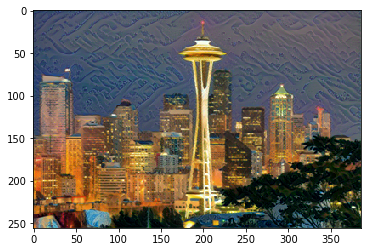

Total Loss: 17998004.0


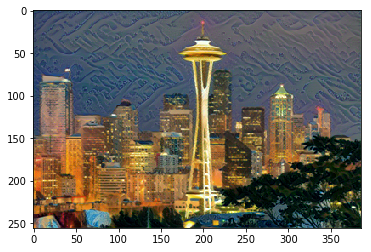

Total Loss: 14974515.0


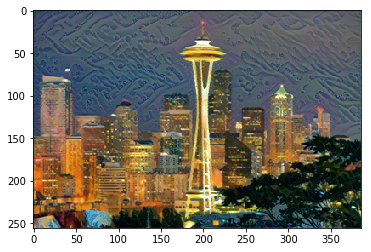

Total Loss: 12811473.0


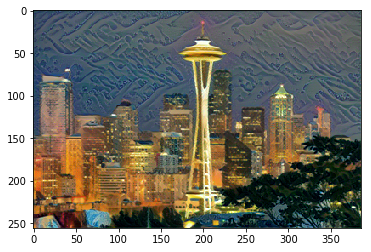

Total Loss: 11197369.0


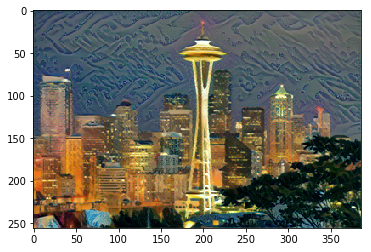

Total Loss: 9953323.0


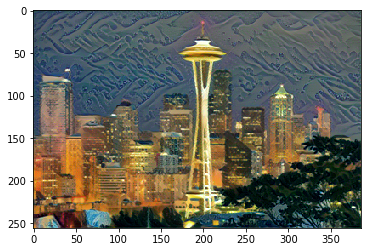

Total Loss: 8962763.0


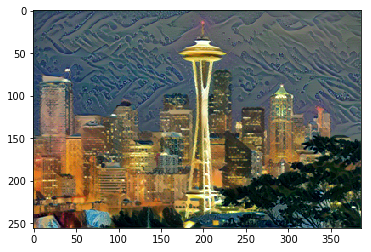

Total Loss: 8154179.0


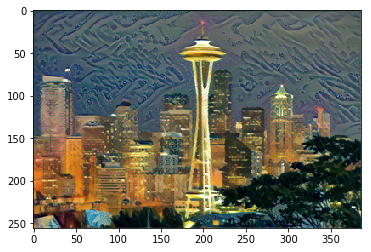

Total Loss: 7481331.0


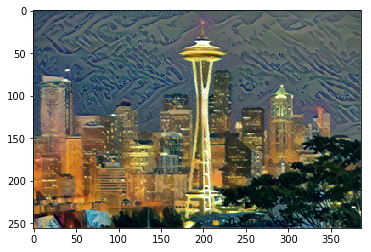

Total Loss: 6912005.5


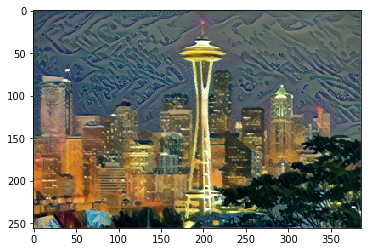

Total Loss: 6422209.5


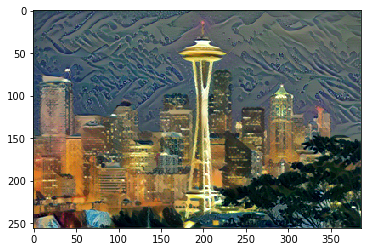

Total Loss: 5995260.0


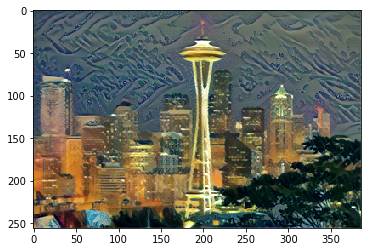

Total Loss: 5620009.0


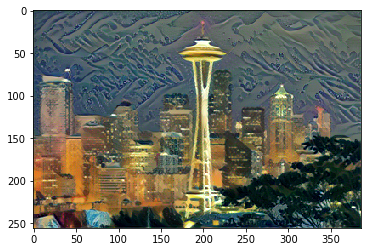

Total Loss: 5286591.0


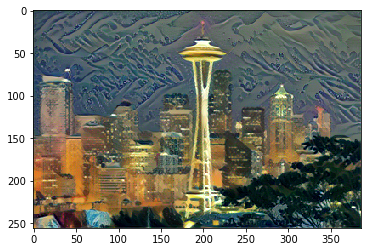

Total Loss: 4988442.5


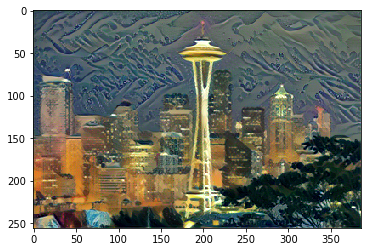

In [44]:
optimizer = torch.optim.Adam([output],lr=0.001)
steps = 2000

for step in range(steps):
  
  output_features = get_features(output,vgg19)
  
  # -- Calculate Content Loss --
  content_loss = torch.mean((output_features['conv4_2'] - gt_content_features['conv4_2'])**2)
  
  # -- Calculate Style Loss --
  style_loss = 0 # init style loss
  for layer in style_weights:
    output_feature = output_features[layer]
    output_gram = gram_matrix(output_feature)
    _,d,h,w = output_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((output_gram - style_gram)**2)
    style_loss += layer_style_loss/(d*h*w)
  
  # -- Calculate Total Loss --
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  # Update Output Image
  optimizer.zero_grad()
  total_loss.backward(retain_graph=True)
  optimizer.step()
  
  if(step % 100 == 0):
    print('Total Loss: {}'.format(total_loss))
    plt.imshow(unnorm_img(output))
    plt.show()

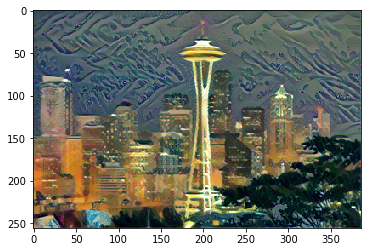

In [45]:
plt.imshow(unnorm_img(output))